In [32]:
import os
import keras
import mne
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
from mne.channels import make_standard_montage
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [33]:
def annotations_from_eGUI(raw, egui):
    """
    function to create mne annotations for a mne.Raw object from a time series
    containing the state of the display
    """

    codes = []
    starts = []
    current_state = None

    for i in range(len(egui)):
        if egui[i][0] != current_state:
            starts.append(i)
            current_state = egui[i][0]
            codes.append(str(egui[i][0]))

    starts.append(len(egui))
    codes = np.array(codes)
    sf = raw.info.get("sfreq")
    starts = np.array(starts) / sf
    durations = starts[1:] - starts[:-1]
    starts = starts[:-1]

    raw.set_annotations(
        mne.Annotations(onset=starts, duration=durations, description=codes)
    )


def raw_from_mat(file):
    """function to load data from a .mat file into a mne.Raw object"""
    mat = scipy.io.loadmat(os.path.join(data_dir, file))

    sampling_freq = mat["o"][0][0][2][0][0]
    n_samples = mat["o"][0][0][3][0][0]
    ch_names = [element[0][0] for element in mat["o"][0][0][6]]

    df = pd.DataFrame(mat["o"][0][0][5], columns=ch_names)
    df = df.drop(columns=["X5"])  # unsupported channel
    df = df.T
    ch_names.remove("X5")

    ch_types = ["eeg"] * 21
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    raw = mne.io.RawArray(df.to_numpy(), info)

    montage = make_standard_montage("standard_prefixed")
    raw.set_montage(montage)

    raw.load_data().set_eeg_reference(ref_channels="average")
    annotations_from_eGUI(raw, mat["o"][0][0][4])
    return raw


def filter_raw(raw):
    return raw.load_data().filter(0.1, 30, method="fir", phase="zero-double")


def get_epochs(raw, event_id):
    """function to extract mne epochs from a mne.Raw object"""
    metadata_tmin, metadata_tmax = -1, 1
    all_events, all_event_id = mne.events_from_annotations(
        raw,
        event_id=event_id,
    )
    metadata, events, event_id = mne.epochs.make_metadata(
        events=all_events,
        event_id=event_id,
        tmin=metadata_tmin,
        tmax=metadata_tmax,
        sfreq=raw.info["sfreq"],
    )
    print(raw.info["sfreq"])
    return mne.Epochs(raw, events, event_id, tmin=-1.0, tmax=1.0, baseline=(-1, 1))


# Data Loading and Preparation

We will create now several Datasets on which  we will test our methods.

 - `epochs_NoMT` will correspond to the data which is our baseline and where the subject is in a resting position whith no input on the screen. ( only take events "0")
 - `epochs_NOMT_only_code_2` will correspond to the data which comes from the same trails and session of the epochs_NoMT data, but here we select epochs where something is shown on the screen. (only take events "2")
 - `epochs_FREEFORM` will correspond to the data which comes from a diffrent session and here the subject can voluntarily  press buttons (either left or right)

In [34]:
# set up paths of data
data_dir = os.path.dirname("./data/")
data_files = os.listdir(data_dir)


In [35]:
# load data to raw objects
raw_NoMT = [raw_from_mat(file) for file in data_files if "NoMT" in file]
raw_FREEFORM = [raw_from_mat(file) for file in data_files if "FREEFORM" in file]


Creating RawArray with float64 data, n_channels=21, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 d

In [36]:
# epoch data
epochs_NoMT = [get_epochs(file, {"0": 1}) for file in raw_NoMT]
epochs_FREEFORM = [get_epochs(file, {"1": 2, "2": 3}) for file in raw_FREEFORM]
epochs_NOMT_only_code_2 = [get_epochs(file, {"2": 3}) for file in raw_NoMT]


Used Annotations descriptions: ['0']
200.0
Not setting metadata
966 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
960 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
963 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0

In [37]:
# put data in arrays
epochs_data_NOMT = [file.get_data() for file in epochs_NoMT]
epochs_data_FREEFORM = [file.get_data() for file in epochs_FREEFORM]
epochs_Data_NOMT_2 = [file.get_data() for file in epochs_NOMT_only_code_2]

X_NOMT = np.vstack(epochs_data_NOMT)
X_free = np.vstack(epochs_data_FREEFORM)
X_nomt_2 = np.vstack(epochs_Data_NOMT_2)

np.random.shuffle(X_NOMT)
np.random.shuffle(X_free)
np.random.shuffle(X_nomt_2)

print(X_NOMT.shape)
print(X_free.shape)
print(X_nomt_2.shape)


Using data from preloaded Raw for 966 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 960 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 963 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 967 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 739 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 688 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 700 events and 401 original time points ...
0 bad epochs dropped
Using data

# Data Preprocessing

In [38]:
# split train data from nomt data
N = X_NOMT.shape[0]
X_NOMT = np.moveaxis(X_NOMT, 1, 2)
X_free = np.moveaxis(X_free, 1, 2)
X_nomt_2 = np.moveaxis(X_nomt_2, 1, 2)

X_nomt_train = X_NOMT[:5000]
X_nomt_test = X_NOMT[5000:]


In [39]:
print(X_nomt_train.shape)
print(X_nomt_test.shape)
print(X_free.shape)
print(X_nomt_2.shape)


(5000, 401, 21)
(1753, 401, 21)
(2127, 401, 21)
(1114, 401, 21)


In [40]:
# normalise data
norm_X_NOMT = layers.Normalization()
norm_X_free = layers.Normalization()
norm_X_nomt_2 = layers.Normalization()

norm_X_NOMT.adapt(X_NOMT.astype(float))
norm_X_free.adapt(X_free.astype(float))
norm_X_nomt_2.adapt(X_nomt_2.astype(float))

scaled_X_nomt_train = norm_X_NOMT(X_nomt_train)
scaled_X_nomt_test = norm_X_NOMT(X_nomt_test)
scaled_X_free = norm_X_free(X_free)
scaled_X_nomt_2 = norm_X_nomt_2(X_nomt_2)


# Helper functions

In [41]:
def calc_reconstruction_error(ae, A, B, pr=True):
    err = []
    err2 = []
    for i in A:
        # need to expand here because the flatten layer assumes that the first dimension is the number of samples
        i = np.expand_dims(i, axis=0)
        err.append((np.square(i - ae.call(i))).mean())
    print("###################")

    for j in B:
        j = np.expand_dims(j, axis=0)
        err2.append((np.square(j - ae.call(j))).mean())
    if pr:
        print("Mean reconstruction errors : ")
        print(np.array(err).mean())
        print(np.array(err2).mean())
    return err, err2


In [42]:
def calc_accuracy(model, A, B, th):
    """function to compute the accuracy of event classification by thresholding the reconstruction error"""
    a, b = calc_reconstruction_error(model, A, B, pr=False)
    first = [1 if i < th else 0 for i in a]
    last = [1 if i > th else 0 for i in b]
    last2 = [0 if i > th else 1 for i in b]
    return sum(np.concatenate((first, last))) / len(
        np.concatenate((first, last))
    ), np.concatenate((first, last2))


In [43]:
def train_model(ae, X_train, X_test, lr, epochs, bs):
    hist = ae.fit(
        X_train,
        X_train,
        epochs=epochs,
        batch_size=bs,
        shuffle=True,
        validation_data=(X_test, X_test),
    )

    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()
    return (
        hist.history["loss"],
        hist.history["val_loss"],
        lr.learning_rate.numpy(),
        epochs,
        bs,
    )


In [44]:
def print_and_calc_results(model, A, A_title, B, B_title, scale=True):
    ar1, ar2 = calc_reconstruction_error(model, A, B, pr=False)
    print("Reconstruction Error of :")
    print(A_title)
    print("Mean")
    print(np.mean(ar1))
    print("Median")
    print(np.median(ar1))
    print("Reconstruction Error of :")
    print(B_title)
    print("Mean")
    print(np.mean(ar2))
    print("Median")
    print(np.median(ar2))

    if scale:
        _ = plt.hist(ar1, bins=100, range=(0, 2), label=A_title)
        _ = plt.hist(ar2, bins=100, range=(0, 2), label=B_title)
        plt.title("Histogram of Reconstruction error")
        plt.xlim((0, 2))
        plt.legend()
        plt.xlabel("reconstruction error")
        plt.ylabel("frequency")
        plt.show()
    else:
        _ = plt.hist(ar1, bins=200, range=(0, 500), label=A_title)
        _ = plt.hist(ar2, bins=200, range=(0, 500), label=B_title)
        plt.title("Histogram of Reconstruction error")
        plt.xlabel("reconstruction error")
        plt.ylabel("frequency")
        plt.legend()
        plt.show()


In [45]:
def acc_over_n_runs(ae, A, B, th, n):
    A = A.numpy()
    B = B.numpy()
    erg = []
    for i in np.arange(n):
        np.take(A, np.random.permutation(A.shape[0]), axis=0, out=A)
        np.take(B, np.random.permutation(B.shape[0]), axis=0, out=B)
        acc, _ = calc_accuracy(ae, A[:500], B[:500], th)
        erg.append(acc)
    print(erg)
    print(f"Final acc over {n} runs:", np.mean(erg))


# Convolutional Autoencoder

In [46]:
keras.backend.clear_session()
encoding_dim = 50


class ConvAutoencoder(Model):
    def __init__(self, encoding_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(
                    shape=(X_nomt_train.shape[1], X_nomt_train.shape[2])
                ),  # 401, 21
                layers.Conv1D(42, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(84, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.ZeroPadding1D(padding=((1,0))),
                layers.Flatten(),
                layers.Dense(encoding_dim, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(101 * 84, activation="relu", use_bias=False),
                layers.Reshape((101, 84)),
                layers.Conv1DTranspose(
                    84, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    42, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1D(
                    X_nomt_train.shape[2],
                    kernel_size=3,
                    activation=None,
                    padding="same",
                ),
                layers.Cropping1D(cropping=(2, 1)),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


conv_autoencoder = ConvAutoencoder(encoding_dim)


In [47]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


In [48]:
conv_autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 401, 42)           2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 401, 42)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 201, 42)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 201, 84)           10668     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 201, 84)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 101, 84)          0         
 1D)                                                    

In [49]:
# conv_autoencoder.decoder.summary()


Epoch 1/100
20/20 [==============================] - 5s 166ms/step - loss: 0.8428 - val_loss: 0.6307
Epoch 2/100
20/20 [==============================] - 3s 157ms/step - loss: 0.5916 - val_loss: 0.5001
Epoch 3/100
20/20 [==============================] - 3s 157ms/step - loss: 0.5026 - val_loss: 0.4572
Epoch 4/100
20/20 [==============================] - 3s 160ms/step - loss: 0.4609 - val_loss: 0.4293
Epoch 5/100
20/20 [==============================] - 3s 161ms/step - loss: 0.4365 - val_loss: 0.4166
Epoch 6/100
20/20 [==============================] - 3s 163ms/step - loss: 0.4209 - val_loss: 0.4054
Epoch 7/100
20/20 [==============================] - 3s 163ms/step - loss: 0.4067 - val_loss: 0.3964
Epoch 8/100
20/20 [==============================] - 3s 161ms/step - loss: 0.3923 - val_loss: 0.3891
Epoch 9/100
20/20 [==============================] - 3s 164ms/step - loss: 0.3799 - val_loss: 0.3822
Epoch 10/100
20/20 [==============================] - 3s 161ms/step - loss: 0.3698 - val_lo

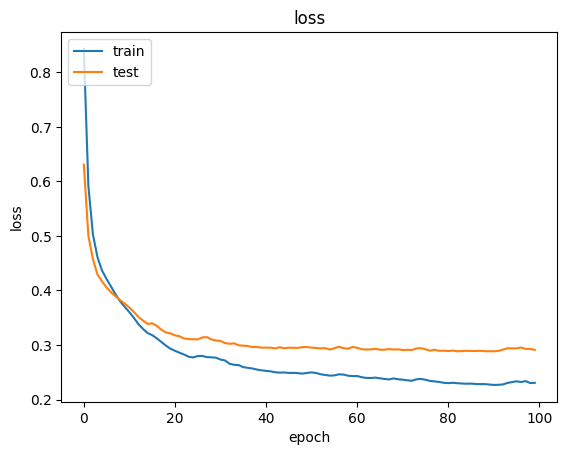

([0.8428210020065308,
  0.59162437915802,
  0.5026366114616394,
  0.46094560623168945,
  0.436464786529541,
  0.4209064543247223,
  0.40668216347694397,
  0.39227136969566345,
  0.3798603415489197,
  0.3698098957538605,
  0.3601018190383911,
  0.3495649993419647,
  0.3381871283054352,
  0.32937291264533997,
  0.3218879699707031,
  0.31803715229034424,
  0.3122749626636505,
  0.30564069747924805,
  0.29900556802749634,
  0.2931423783302307,
  0.28939729928970337,
  0.2858029305934906,
  0.2825008034706116,
  0.2785007953643799,
  0.2771309018135071,
  0.2796437740325928,
  0.27993544936180115,
  0.2777705788612366,
  0.27734678983688354,
  0.27672627568244934,
  0.27328717708587646,
  0.2715260088443756,
  0.2656356692314148,
  0.26365628838539124,
  0.26301971077919006,
  0.25939416885375977,
  0.25809794664382935,
  0.25688111782073975,
  0.25494128465652466,
  0.2534961402416229,
  0.2525089383125305,
  0.2516716420650482,
  0.24997682869434357,
  0.24934670329093933,
  0.24959743022

In [50]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=100, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.32027975
Median
0.1996785
Reconstruction Error of :
X_free
Mean
0.64917845
Median
0.60304785


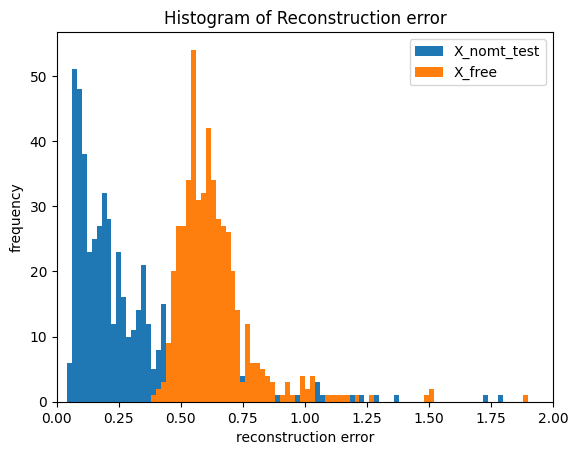

In [51]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)


In [53]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.4, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.921, 0.917, 0.9, 0.914, 0.918, 0.905, 0.902, 0.911, 0.91, 0.915]
Final acc over 10 runs: 0.9113


In [ ]:
# calc_accuracy(test_error, freeform_error, 1)


# Convolutional Autoencoder - Variants
## Increased encoding space

In [54]:
conv_autoencoder = ConvAutoencoder(encoding_dim=256)

opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


Epoch 1/100
20/20 [==============================] - 5s 193ms/step - loss: 0.7812 - val_loss: 0.5504
Epoch 2/100
20/20 [==============================] - 4s 180ms/step - loss: 0.5207 - val_loss: 0.4566
Epoch 3/100
20/20 [==============================] - 4s 182ms/step - loss: 0.4506 - val_loss: 0.4201
Epoch 4/100
20/20 [==============================] - 4s 184ms/step - loss: 0.4179 - val_loss: 0.4059
Epoch 5/100
20/20 [==============================] - 4s 180ms/step - loss: 0.3948 - val_loss: 0.3845
Epoch 6/100
20/20 [==============================] - 4s 179ms/step - loss: 0.3666 - val_loss: 0.3692
Epoch 7/100
20/20 [==============================] - 4s 181ms/step - loss: 0.3489 - val_loss: 0.3582
Epoch 8/100
20/20 [==============================] - 4s 183ms/step - loss: 0.3324 - val_loss: 0.3475
Epoch 9/100
20/20 [==============================] - 4s 190ms/step - loss: 0.3143 - val_loss: 0.3312
Epoch 10/100
20/20 [==============================] - 4s 182ms/step - loss: 0.2966 - val_lo

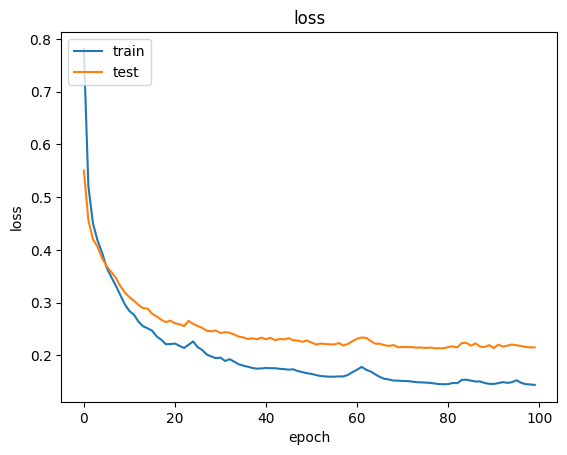

([0.7812194228172302,
  0.5206828117370605,
  0.4505574107170105,
  0.4178747534751892,
  0.39481717348098755,
  0.36655089259147644,
  0.34888672828674316,
  0.33241650462150574,
  0.31432831287384033,
  0.29660433530807495,
  0.28385433554649353,
  0.2770499289035797,
  0.2637477517127991,
  0.2550194561481476,
  0.2510184943675995,
  0.24662818014621735,
  0.23566614091396332,
  0.22939340770244598,
  0.22097265720367432,
  0.2212233692407608,
  0.22212418913841248,
  0.21778735518455505,
  0.2137978971004486,
  0.21992644667625427,
  0.22614365816116333,
  0.21515537798404694,
  0.20996735990047455,
  0.20123054087162018,
  0.19770927727222443,
  0.1944471299648285,
  0.1955041140317917,
  0.1891346126794815,
  0.19249263405799866,
  0.18797501921653748,
  0.18277223408222198,
  0.180358424782753,
  0.178148090839386,
  0.17583031952381134,
  0.17452704906463623,
  0.17499113082885742,
  0.17576026916503906,
  0.1753876656293869,
  0.17534500360488892,
  0.174276664853096,
  0.1735

In [55]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=100, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.24402161
Median
0.13725924
Reconstruction Error of :
X_free
Mean
0.42459446
Median
0.38303673


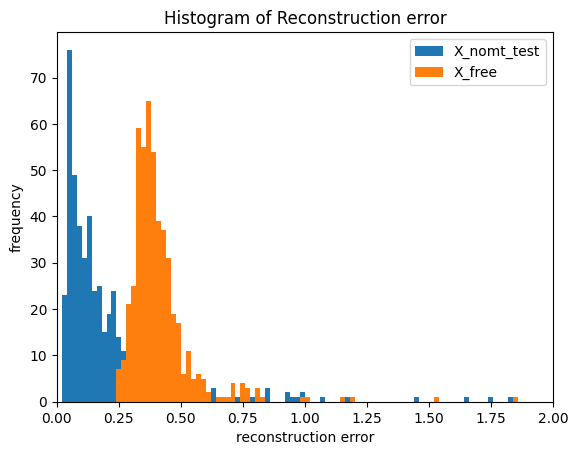

In [56]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)


In [61]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.25, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.875, 0.889, 0.892, 0.877, 0.874, 0.878, 0.888, 0.9, 0.885, 0.883]
Final acc over 10 runs: 0.8841000000000001


## More layers

In [62]:
keras.backend.clear_session()
encoding_dim = 50


class ConvAutoencoder(Model):
    def __init__(self, encoding_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Input(
                    shape=(X_nomt_train.shape[1], X_nomt_train.shape[2])
                ),  # 401, 21
                layers.Conv1D(42, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(84, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.Conv1D(168, 3, activation=None, padding="same"),
                layers.LeakyReLU(),
                layers.MaxPooling1D(pool_size=2, padding="same"),
                layers.ZeroPadding1D(padding=((1,0))),
                layers.Flatten(),
                layers.Dense(encoding_dim, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(51 * 168, activation="relu", use_bias=False),
                layers.Reshape((51, 168)),
                layers.Conv1DTranspose(
                    168, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    84, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1DTranspose(
                    42, kernel_size=3, activation=None, padding="same"
                ),
                layers.LeakyReLU(),
                layers.UpSampling1D(),
                layers.Conv1D(
                    X_nomt_train.shape[2],
                    kernel_size=3,
                    activation=None,
                    padding="same",
                ),
                layers.Cropping1D(cropping=(6, 1)),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


conv_autoencoder = ConvAutoencoder(encoding_dim)


In [63]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
conv_autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


In [64]:
conv_autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 401, 42)           2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 401, 42)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 201, 42)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 201, 84)           10668     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 201, 84)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 101, 84)          0         
 1D)                                                    

In [65]:
# conv_autoencoder.decoder.summary()


Epoch 1/100
20/20 [==============================] - 7s 243ms/step - loss: 0.8566 - val_loss: 0.6491
Epoch 2/100
20/20 [==============================] - 5s 233ms/step - loss: 0.6074 - val_loss: 0.5049
Epoch 3/100
20/20 [==============================] - 5s 227ms/step - loss: 0.4924 - val_loss: 0.4440
Epoch 4/100
20/20 [==============================] - 5s 227ms/step - loss: 0.4468 - val_loss: 0.4214
Epoch 5/100
20/20 [==============================] - 5s 228ms/step - loss: 0.4260 - val_loss: 0.4086
Epoch 6/100
20/20 [==============================] - 5s 230ms/step - loss: 0.4079 - val_loss: 0.4010
Epoch 7/100
20/20 [==============================] - 5s 231ms/step - loss: 0.3958 - val_loss: 0.3919
Epoch 8/100
20/20 [==============================] - 5s 235ms/step - loss: 0.3842 - val_loss: 0.3860
Epoch 9/100
20/20 [==============================] - 5s 237ms/step - loss: 0.3757 - val_loss: 0.3824
Epoch 10/100
20/20 [==============================] - 5s 241ms/step - loss: 0.3641 - val_lo

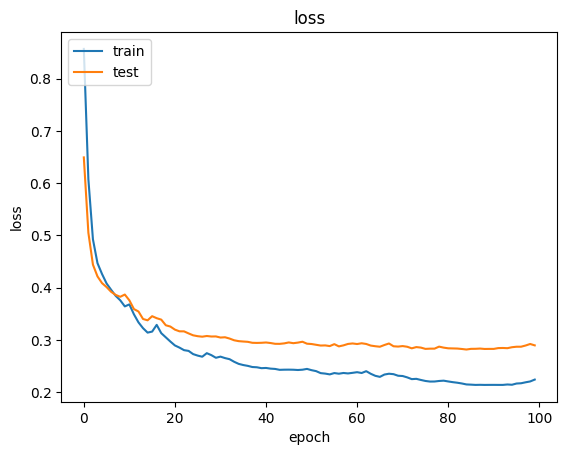

([0.8566218018531799,
  0.6074214577674866,
  0.49243471026420593,
  0.4467625021934509,
  0.4259871542453766,
  0.4078740179538727,
  0.39576080441474915,
  0.3841937184333801,
  0.3756980895996094,
  0.36407777667045593,
  0.36789247393608093,
  0.34893855452537537,
  0.3334994614124298,
  0.32238444685935974,
  0.31393349170684814,
  0.3158584535121918,
  0.32871827483177185,
  0.31286489963531494,
  0.30486148595809937,
  0.29685497283935547,
  0.2893613874912262,
  0.2852361798286438,
  0.2803732752799988,
  0.2789367139339447,
  0.27281060814857483,
  0.26995018124580383,
  0.2678099274635315,
  0.274601548910141,
  0.2708408534526825,
  0.2657879590988159,
  0.26798033714294434,
  0.2651841938495636,
  0.26308777928352356,
  0.258143812417984,
  0.254123330116272,
  0.2518971562385559,
  0.2503112256526947,
  0.2480984628200531,
  0.24761828780174255,
  0.24589987099170685,
  0.24631550908088684,
  0.24503396451473236,
  0.24444416165351868,
  0.24272285401821136,
  0.2430109381

In [66]:
train_model(
    conv_autoencoder, scaled_X_nomt_train, scaled_X_nomt_test, opt, epochs=100, bs=256
)


###################
Reconstruction Error of :
X_nomt_test
Mean
0.31996152
Median
0.19738552
Reconstruction Error of :
X_free
Mean
0.6446158
Median
0.5971612


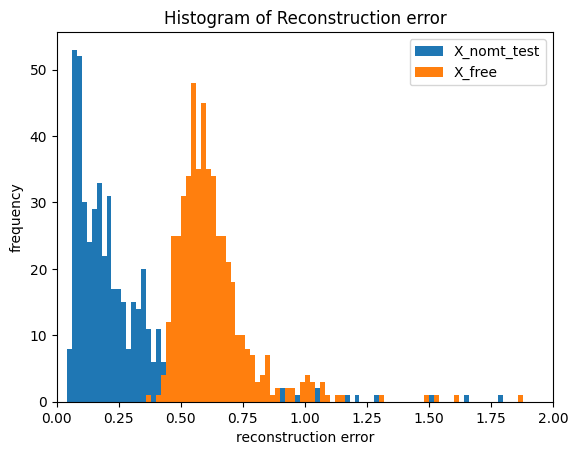

In [67]:
print_and_calc_results(
    conv_autoencoder,
    scaled_X_nomt_test[:500],
    "X_nomt_test",
    scaled_X_free[:500],
    "X_free",
)

In [68]:
acc_over_n_runs(conv_autoencoder, scaled_X_nomt_test, scaled_X_free, 0.4, 10)


###################
###################
###################
###################
###################
###################
###################
###################
###################
###################
[0.917, 0.904, 0.927, 0.911, 0.91, 0.924, 0.926, 0.906, 0.92, 0.916]
Final acc over 10 runs: 0.9161000000000001
